## 8.5 Implementation of Recurrent Neural Networks from Scratch

In [2]:
%matplotlib inline
from d2l import mxnet as d2l
import math
from mxnet import autograd,gluon,np,npx
npx.set_np()

In [3]:
batch_size, num_steps=32,35
train_iter, vocab=d2l.load_data_time_machine(batch_size,num_steps)

In [4]:
# 8.5.1 One-Hot Encoding
len(vocab), npx.one_hot(np.array([0,2]),len(vocab))

(28,
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [5]:
X=np.arange(10).reshape((2,5))
npx.one_hot(X.T,len(vocab)).shape

(5, 2, 28)

In [6]:
# 8.5.2 Initializing the Model Parameters
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    # def normal(shape):
        # return np.random.normal(scale=0.01, size=shape, ctx=device)

    normal=lambda shape:np.random.normal(scale=0.01, size=shape, ctx=device)
    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = np.zeros(num_hiddens, ctx=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = np.zeros(num_outputs, ctx=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.attach_grad()
    return params

In [9]:
# 8.5.3 RNN Model
def init_rnn_state(batch_size, num_hiddens, device):
    return (np.zeros((batch_size, num_hiddens), ctx=device),)

In [10]:
def rnn(inputs, state, params):
    # Shape of `inputs`: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = np.tanh(np.dot(X, W_xh) + np.dot(H, W_hh) + b_h)
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H,)

In [11]:
class RNNModelScratch:  #@save
    """An RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = npx.one_hot(X.T, self.vocab_size)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, ctx):
        return self.init_state(batch_size, self.num_hiddens, ctx)

In [12]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.as_in_context(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

((10, 28), 1, (2, 512))

In [13]:
# 8.5.4 Prediction
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, ctx=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: np.array([outputs[-1]], ctx=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [16]:
predict_ch8('time traveller ', 20, net, vocab, d2l.try_gpu())

'time traveller iiiiiiiiiiiiiiiiiiii'

### 8.5.5 Gradient Clipping
梯度裁剪：为了应对梯度爆炸，把所有模型参数梯度的元素拼接成一个向量 $\mathbf{g}$，并且设置裁剪的阈值为 $\theta$，则裁剪后的梯度 $\min(\frac{\theta}{||\mathbf{g}||},1)\mathbf{g}$ 的 $L_2$ 范数不超过 $\theta$。

In [17]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, gluon.Block):
        params = [p.data() for p in net.collect_params().values()]
    else:
        params = net.params
    norm = math.sqrt(sum((p.grad**2).sum() for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

### 8.5.6 Training

1.  使用困惑度评价模型
2.  在迭代模型参数前裁剪梯度
3.  对时序数据采用不同采样方法将导致隐藏状态初始化的不同

In [18]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a model within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], ctx=device)
        else:
            for s in state:
                s.detach()
        y = Y.T.reshape(-1)
        X, y = X.as_in_ctx(device), y.as_in_ctx(device)
        with autograd.record():
            y_hat, state = net(X, state)
            l = loss(y_hat, y).mean()
        l.backward()
        grad_clipping(net, 1)
        updater(batch_size=1)  # Since the `mean` function has been invoked
        metric.add(l * y.size, y.size)
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [19]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,  #@save
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, gluon.Block):
        net.initialize(ctx=device, force_reinit=True, init=init.Normal(0.01))
        trainer = gluon.Trainer(net.collect_params(), 'sgd',
                                {'learning_rate': lr})
        updater = lambda batch_size: trainer.step(batch_size)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.1, 26695.2 tokens/sec on gpu(0)
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


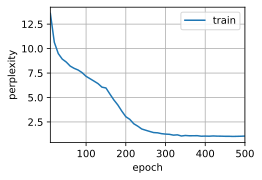

In [20]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

perplexity 1.2, 25538.9 tokens/sec on gpu(0)
time traveller but now you begin to seethe object of my investig
traveller after the pauserequired for the proper assimilati


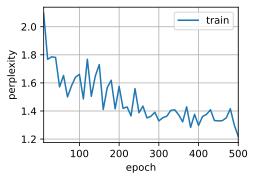

In [21]:
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)